# **Clone Git Repository**

---

Clone git agar dapat load data langsung dari git repository. Dataset yang digunakan didapat kan dari kaggle: [Book Recommendation Dataset](https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset)

In [1]:
!git clone https://github.com/ziszz/book-recommendation.git

Cloning into 'book-recommendation'...
remote: Enumerating objects: 133, done.
remote: Counting objects: 100% (102/102), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 133 (delta 50), reused 55 (delta 17), pack-reused 31
Receiving objects: 100% (133/133), 28.92 MiB | 21.49 MiB/s, done.
Resolving deltas: 100% (56/56), done.


# **Import library yang diperlukan**

---



In [2]:
import pandas as pd
import numpy as np
import zipfile
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

from zipfile import ZipFile
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score

# **Data Loading**

---



In [3]:
books = pd.read_csv('/content/book-recommendation/datasets/Books.csv')
ratings = pd.read_csv('/content/book-recommendation/datasets/Ratings.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
books

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...
...,...,...,...,...,...,...,...,...
271355,0440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm),http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...
271356,0525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...
271357,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker,2004,HarperSanFrancisco,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...
271358,0192126040,Republic (World's Classics),Plato,1996,Oxford University Press,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...


In [5]:
ratings

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
...,...,...,...
1149775,276704,1563526298,9
1149776,276706,0679447156,0
1149777,276709,0515107662,10
1149778,276721,0590442449,10


# **Data Understanding**

---

## Variabel-variabel pada dataset adalah sebagai berikut:

### **Books.csv**
  * `ISBN`: Kode pengidentifikasian buku yang bersifat unik.
  * `Book-Title`: Judul Buku.
  * `Book-Author`: Nama pengarang buku.
  * `Year-Of-Publication`: Tahun penerbitan buku.
  * `Publisher`: Pihak penerbit buku.
  * `Image-URL-S`: URL yang menautkan ke gambar sampul berukuran kecil.
  * `Image-URL-M`: URL yang menautkan ke gambar sampul berukuran normal.
  * `Image-URL-L`: URL yang menautkan ke gambar sampul berukuran besar.

### **Ratings.csv**
  * `User-ID`: Nomer unik user yang memberikan rating.
  * `ISBN`: Kode pengidentifikasian buku yang bersifat unik.
  * `Book-Rating`: Skor dari rating yang diberikan.


## **Menghitung jumlah Buku, User dan Rating**

In [6]:
print('Jumlah data buku: ', len(books['ISBN'].unique()))
print('Jumlah data user yang memberikan rating: ', len(ratings['User-ID'].unique()))
print('Jumlah data rating pada buku: ', len(ratings['ISBN'].unique()))

Jumlah data buku:  271360
Jumlah data user yang memberikan rating:  105283
Jumlah data rating pada buku:  340556


## **Memeriksa informasi pada data**

In [7]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271359 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


Terlihat dari data buku di atas. Semua kolom data memiliki type data object

In [8]:
book_list = books['Book-Title'].value_counts().keys()
jumlah = books['Book-Title'].value_counts()

book_count = pd.DataFrame({'Book-Title': book_list, 'Jumlah': jumlah}).reset_index(drop=True)
book_count

,Book-Title,Jumlah
0,Selected Poems,27
1,Little Women,24
2,Wuthering Heights,21
3,The Secret Garden,20
4,Dracula,20
...,...,...
242130,What Every Kid Should Know,1
242131,The Seventh Enemy (A Brady Coyne Mystery),1
242132,A Brace of Skeet,1
242133,"The Yellow Admiral (O'Brian, Patrick, Aubrey/M...",1


In [9]:
author_list = books['Book-Author'].value_counts().keys()
jumlah = books['Book-Author'].value_counts()

author_count = pd.DataFrame({'Book-Author': author_list, 'Jumlah': jumlah}).reset_index(drop=True)
author_count

,Book-Author,Jumlah
0,Agatha Christie,632
1,William Shakespeare,567
2,Stephen King,524
3,Ann M. Martin,423
4,Carolyn Keene,373
...,...,...
102018,Linda Jackson,1
102019,Artiste C. Arthur,1
102020,Emily Pearl Kingsley,1
102021,Jean Cassels,1


In [10]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


Sedangkan, untuk data rating terdapat 2 tipe pada data yaitu numerik (int64) dan object.

In [11]:
rating_list = ratings['Book-Rating'].value_counts().keys()
jumlah = ratings['Book-Rating'].value_counts()

rating_count = pd.DataFrame({'Ratings': rating_list, 'Jumlah': jumlah}).reset_index(drop=True)
rating_count

,Ratings,Jumlah
0,0,716109
1,8,103736
2,10,78610
3,7,76457
4,9,67541
5,5,50974
6,6,36924
7,4,8904
8,3,5996
9,2,2759


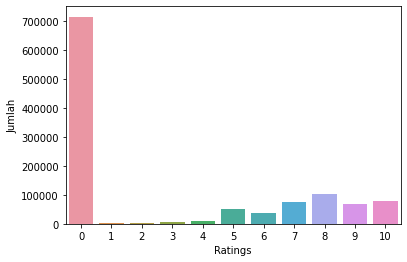

In [12]:
sns.barplot(data=rating_count, x='Ratings', y='Jumlah')
plt.show()

Dari visualisasi di atas, diketahui bahwa nilai maksimum rating adalah 10 dan nilai minimumnya adalah 0. Artinya, skala rating berkisar antara 0 hingga 10.

## **Memeriksa missing value**


In [13]:
books.isnull().sum()

ISBN                   0
Book-Title             0
Book-Author            1
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64

In [14]:
ratings.isnull().sum()

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64


Jika dilihat dari data buku dan data rating di atas. Terdapat sedikit missing value pada data buku, sedangkan pada data rating tidak memiliki missing value.

## **Memeriksa duplikasi data**


In [15]:
for col in books.columns:
  print(f'{col}: {books[col].duplicated().sum()}')

ISBN: 0
Book-Title: 29225
Book-Author: 169336
Year-Of-Publication: 271158
Publisher: 254552
Image-URL-S: 316
Image-URL-M: 316
Image-URL-L: 318


Dapat dilihat pada output diatas. Tidak terdapat duplikat pada data ISBN tetapi terdapat banyak duplikat pada data lainnya.

In [16]:
for col in ratings.columns:
  print(f'{col}: {ratings[col].duplicated().sum()}')

User-ID: 1044497
ISBN: 809224
Book-Rating: 1149769


Begitupun pada data rating, terdapat banyak duplikat pada data. Tetapi ini hal yang wajar sebab tiap user dapat memberikan rating pada tiap buku yang berbeda dan buku yang berbeda dapat menerima rating dari user yang berbeda pula.

# **Content-Based Filtering**
---
## **Data Preparation**



### **Menghapus data yang tidak diperlukan**
Sistem rekomendasi ini hanya memerlukan data author dan rating sebagai fitur untuk model. Beberapa kolom data seperti `'Year-Of-Publication', 'Publisher', 'Image-URL-M', 'Image-URL-L'` tidak akan digunakan untuk sistem rekomendasi ini. Jadi data tersebut bisa dihapus.

In [17]:
unused_columns = ['Year-Of-Publication', 'Publisher', 'Image-URL-M', 'Image-URL-L']
books.drop(unused_columns, axis=1, inplace=True)
books

,ISBN,Book-Title,Book-Author,Image-URL-S
0,0195153448,Classical Mythology,Mark P. O. Morford,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,http://images.amazon.com/images/P/0393045218.0...
...,...,...,...,...
271355,0440400988,There's a Bat in Bunk Five,Paula Danziger,http://images.amazon.com/images/P/0440400988.0...
271356,0525447644,From One to One Hundred,Teri Sloat,http://images.amazon.com/images/P/0525447644.0...
271357,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker,http://images.amazon.com/images/P/006008667X.0...
271358,0192126040,Republic (World's Classics),Plato,http://images.amazon.com/images/P/0192126040.0...


### **Melakukan penggabungan data**
Menggabungkan data buku dan rating.

In [18]:
new_ratings = ratings.merge(books,on='ISBN')
new_ratings = new_ratings.groupby('Book-Title').sum()['Book-Rating'].reset_index()
new_ratings.rename(columns={'Book-Rating':'Num-Ratings'}, inplace=True)

In [19]:
new_books = pd.DataFrame({'Book-Title': books['Book-Title'].unique()})
new_books = pd.merge(new_books, new_ratings, on='Book-Title', how='left')
new_books = new_books.merge(books, on='Book-Title').drop_duplicates('ISBN')

In [20]:
new_books

,Book-Title,Num-Ratings,ISBN,Book-Author,Image-URL-S
0,Classical Mythology,7.0,0195153448,Mark P. O. Morford,http://images.amazon.com/images/P/0195153448.0...
1,Classical Mythology,7.0,0801319536,Mark P. O. Morford,http://images.amazon.com/images/P/0801319536.0...
2,Clara Callan,69.0,0002005018,Richard Bruce Wright,http://images.amazon.com/images/P/0002005018.0...
3,Decision in Normandy,15.0,0060973129,Carlo D'Este,http://images.amazon.com/images/P/0060973129.0...
4,Flu: The Story of the Great Influenza Pandemic...,47.0,0374157065,Gina Bari Kolata,http://images.amazon.com/images/P/0374157065.0...
...,...,...,...,...,...
271355,Flashpoints: Promise and Peril in a New World,5.0,0449906736,Robin Wright,http://images.amazon.com/images/P/0449906736.0...
271356,From One to One Hundred,4.0,0525447644,Teri Sloat,http://images.amazon.com/images/P/0525447644.0...
271357,Lily Dale : The True Story of the Town that Ta...,0.0,006008667X,Christine Wicker,http://images.amazon.com/images/P/006008667X.0...
271358,Republic (World's Classics),0.0,0192126040,Plato,http://images.amazon.com/images/P/0192126040.0...


### **Menghapus duplikasi data**

In [21]:
new_books = new_books.drop_duplicates('Book-Title').reset_index(drop=True)
len(new_books['ISBN'].unique()), len(new_books['Book-Title'].unique())

(242135, 242135)

### **Mengatasi missing value**

In [22]:
new_books.isnull().sum()

Book-Title        0
Num-Ratings    1064
ISBN              0
Book-Author       1
Image-URL-S       0
dtype: int64

In [23]:
new_books = new_books.dropna()
new_books.shape

(241070, 5)

In [24]:
new_books.isnull().sum()

Book-Title     0
Num-Ratings    0
ISBN           0
Book-Author    0
Image-URL-S    0
dtype: int64

### **Menyeleksi data**
Data yang akan digunakan yaitu data buku dengan total skor rating dari tiap buku di atas 50. 

In [25]:
final_books = new_books[new_books['Num-Ratings'] > 50]
final_books.drop(['ISBN', 'Num-Ratings'], axis=1, inplace=True)
final_books

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Book-Title,Book-Author,Image-URL-S
1,Clara Callan,Richard Bruce Wright,http://images.amazon.com/images/P/0002005018.0...
5,The Kitchen God's Wife,Amy Tan,http://images.amazon.com/images/P/0399135782.0...
14,A Second Chicken Soup for the Woman's Soul (Ch...,Jack Canfield,http://images.amazon.com/images/P/1558746218.0...
18,The Testament,John Grisham,http://images.amazon.com/images/P/0440234743.0...
19,Beloved (Plume Contemporary Fiction),Toni Morrison,http://images.amazon.com/images/P/0452264464.0...
...,...,...,...
138255,Refuge: An Unnatural History of Family and Place,Terry Tempest Williams,http://images.amazon.com/images/P/0679740244.0...
144058,A Letter to Mrs. Roosevelt,C. COCO DE YOUNG,http://images.amazon.com/images/P/0385326335.0...
144734,Selected Poems (Penguin Popular Classics),Walt Whitman,http://images.amazon.com/images/P/0140622209.0...
160381,The Illustrated Alchemist: A Fable About Follo...,Paulo Coelho,http://images.amazon.com/images/P/006019250X.0...


## **Modelling**
### **Tfid Vectorizer**

In [26]:
data = final_books
data.sample(5)

,Book-Title,Book-Author,Image-URL-S
2812,"Startide Rising (The Uplift Saga, Book 2)",David Brin,http://images.amazon.com/images/P/055327418X.0...
52691,The Dragon's Bride,Jo Beverley,http://images.amazon.com/images/P/0451203585.0...
1840,L Is for Lawless (Kinsey Millhone Mysteries),Sue Grafton,http://images.amazon.com/images/P/0805019375.0...
23946,Ravished,Amanda Quick,http://images.amazon.com/images/P/0553293168.0...
34366,A Bend in the River,V.S. NAIPAUL,http://images.amazon.com/images/P/0679722025.0...


In [27]:
tfid = TfidfVectorizer(token_pattern=r"(?u)\b\w\w+\b\s+\w+")
tfid.fit(data['Book-Author']) 

tfid.get_feature_names() 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['aaron naparstek',
 'aaron roy',
 'abbas milani',
 'abby bardi',
 'abigail thomas',
 'adam davies',
 'adam gopnik',
 'adele faber',
 'adele lang',
 'adeline yen',
 'adrian nicole',
 'adriana trigiana',
 'adriana trigiani',
 'agatha christie',
 'agota kristof',
 'ahdaf soueif',
 'ahmed rashid',
 'aimee bender',
 'akif pirincci',
 'akiyuki nosaka',
 'al franken',
 'alain de',
 'alan alexander',
 'alan brown',
 'alan dean',
 'alan furst',
 'alan garner',
 'alan h',
 'alan lightman',
 'alan moore',
 'alan paton',
 'alan watts',
 'alastair reynolds',
 'albert  camus',
 'albert b',
 'albert camus',
 'alcoholics anonymous',
 'aldo leopold',
 'aldous huxley',
 'aleksandr solzhenitsyn',
 'alessandro baricco',
 'alessandro boffa',
 'alex garland',
 'alex haley',
 'alex kava',
 'alex kotlowitz',
 'alexa albert',
 'alexander mccall',
 'alexander solzhenitsyn',
 'alexandra fuller',
 'alexandra lapierre',
 'alexandra ripley',
 'alexandra robbins',
 'alexandre dumas',
 'alfred bester',
 'alfred lans

### **Transformasi data kedalam bentuk matriks**

In [28]:
tfidf_matrix = tfid.fit_transform(data['Book-Author']) 
tfidf_matrix.shape

(8834, 2987)

In [29]:
tfidf_matrix.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

### **Menghitung Cosine Similarity**

In [30]:
cosine_sim = cosine_similarity(tfidf_matrix) 
cosine_sim

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [31]:
cosine_sim_df = pd.DataFrame(cosine_sim, index=data['Book-Title'], columns=data['Book-Title'])
cosine_sim_df

Book-Title,Clara Callan,The Kitchen God's Wife,A Second Chicken Soup for the Woman's Soul (Chicken Soup for the Soul Series),The Testament,Beloved (Plume Contemporary Fiction),Our Dumb Century: The Onion Presents 100 Years of Headlines from America's Finest News Source,New Vegetarian: Bold and Beautiful Recipes for Every Occasion,Wild Animus,Airframe,Timeline,...,Uncle Shelby's ABZ Book: A Primer for Adults Only,From Dawn to Decadence : 500 Years of Western Cultural Life 1500 to the Present,Four &amp; Twenty Blackbirds,Contacto,Cooking With Friends,Refuge: An Unnatural History of Family and Place,A Letter to Mrs. Roosevelt,Selected Poems (Penguin Popular Classics),The Illustrated Alchemist: A Fable About Following Your Dream,Ferne Ufer. Der 3. Band der groÃ?Â?en Highland- Saga.
Book-Title,,,,,,,,,,,,,,,,,,,,,
Clara Callan,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The Kitchen God's Wife,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Second Chicken Soup for the Woman's Soul (Chicken Soup for the Soul Series),0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The Testament,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Beloved (Plume Contemporary Fiction),0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Refuge: An Unnatural History of Family and Place,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
A Letter to Mrs. Roosevelt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
Selected Poems (Penguin Popular Classics),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### **Mendapatkan rekomendasi buku**
Mendapatkan rekomendasi buku berdasarkan author yang sama dengan buku yang telah dibaca oleh user.

In [32]:
def book_recommendations(book_name, similarity_data=cosine_sim_df, items=data, k=5):
  index = similarity_data[book_name].to_numpy().argpartition(range(-1, -(k+1), -1))[::-1]
  closest = similarity_data.columns[index[:k+1]]
  closest = closest.drop(book_name, errors='ignore')

  return pd.DataFrame(closest).merge(items).head(k)

In [33]:
reference_book = 'First Test (Protector of the Small)'
data[data['Book-Title'].eq(reference_book)]

,Book-Title,Book-Author,Image-URL-S
7604,First Test (Protector of the Small),Tamora Pierce,http://images.amazon.com/images/P/0679889175.0...


In [34]:
book_recommendations(reference_book, k=10)

,Book-Title,Book-Author,Image-URL-S
0,Alanna: The First Adventure (Song of the Lione...,Tamora Pierce,http://images.amazon.com/images/P/0679801146.0...
1,"Tris's Book (Circle of Magic, 2)",Tamora Pierce,http://images.amazon.com/images/P/0590554093.0...
2,Lioness Rampant (Song of the Lioness (Paperback)),Tamora Pierce,http://images.amazon.com/images/P/0679801138.0...
3,Sandry's Book (Circle of Magic),Tamora Pierce,http://images.amazon.com/images/P/0590554085.0...
4,Wild Magic (Immortals (Paperback)),TAMORA PIERCE,http://images.amazon.com/images/P/067988288X.0...
5,In the Hand of the Goddess (Song of the Liones...,Tamora Pierce,http://images.amazon.com/images/P/0679801111.0...
6,The Treasure Box,Penelope J. Stokes,http://images.amazon.com/images/P/0849917050.0...
7,Tom Clancy's Op-Center (Tom Clancy's Op Center...,Tom Clancy,http://images.amazon.com/images/P/0425147363.0...
8,Wolf's Hour,Robert McCammon,http://images.amazon.com/images/P/0671731424.0...
9,Naked Came the Manatee,Carl Hiaasen,http://images.amazon.com/images/P/0449001245.0...


## **Evaluation**


Jika dilihat dari hasil rekomendasi di atas. Tingkat presisi dari sistem rekomendasi dengan teknik Content-Based Filtering di atas dapat diketahui melalui seberapa banyak sistem dengan benar merekomendasikan buku berdasarkan authornya. Dari 10 buku yang direkomendasikan hanya 6 buku yang memiliki author yang sama dengan buku `First Test (Protector of the Small)`. 



`Precision@k = (# of recommended items @k that are relevant) / (# of recommended items @k)`

Jadi dapat dikatakan tingkat presisi untuk hasil rekomendasi di atas adalah 6/10 (60%). Hal ini dikarenakan buku dengan author `Tamora Pierce` yang terdapat pada data hanya berjumlah 6.


# **Collaborative Filtering**

---

## **Data Preparation**

### **Melakukan penggabungan data**
Tidak seperti pada teknik Content-Based Filtering. Data yang digunakan di teknik Collaborative Filtering kali ini tidak memerlukan data `Book-Author`, dan `Num-Ratings,`. Sebab pada teknik ini hanya menggunakan rating sebagai acuan sistem rekomendasi.

In [35]:
df = ratings
df = df.merge(new_books, on='ISBN')
df.drop(['Num-Ratings', 'Book-Author'], axis=1, inplace=True)
df

,User-ID,ISBN,Book-Rating,Book-Title,Image-URL-S
0,276725,034545104X,0,Flesh Tones: A Novel,http://images.amazon.com/images/P/034545104X.0...
1,2313,034545104X,5,Flesh Tones: A Novel,http://images.amazon.com/images/P/034545104X.0...
2,6543,034545104X,0,Flesh Tones: A Novel,http://images.amazon.com/images/P/034545104X.0...
3,8680,034545104X,5,Flesh Tones: A Novel,http://images.amazon.com/images/P/034545104X.0...
4,10314,034545104X,9,Flesh Tones: A Novel,http://images.amazon.com/images/P/034545104X.0...
...,...,...,...,...,...
883073,276688,0425150526,0,Death Crosses the Border,http://images.amazon.com/images/P/0425150526.0...
883074,276688,0449907422,0,Jazz Funeral: A Skip Langdon Novel,http://images.amazon.com/images/P/0449907422.0...
883075,276690,0590907301,0,Triplet Trouble and the Class Trip (Triplet Tr...,http://images.amazon.com/images/P/0590907301.0...
883076,276704,0679752714,0,A Desert of Pure Feeling (Vintage Contemporaries),http://images.amazon.com/images/P/0679752714.0...


### **Menyandikan fitur**
Membuat penyandian untuk fitur `User-ID` dan `Book-Title` menjadi dalam bentuk index

In [36]:
user_ids = df['User-ID'].unique().tolist()
user2encoded = {x: i for i, x in enumerate(user_ids)}
encoded2user = {i: x for i, x in enumerate(user_ids)}

In [37]:
book_isbns = df['ISBN'].unique().tolist()
book2encoded = {x: i for i, x in enumerate(book_isbns)}
encoded2book = {i: x for i, x in enumerate(book_isbns)}

In [38]:
df['User-Encoded'] = df['User-ID'].map(user2encoded)
df['Book-Encoded'] = df['ISBN'].map(book2encoded)

In [39]:
num_users = len(user2encoded)
print(num_users)
 
num_books = len(encoded2book)
print(num_books)

df['Book-Rating'] = df['Book-Rating'].values.astype(np.float32)
 
min_rating = min(df['Book-Rating'])
max_rating = max(df['Book-Rating'])

print(f'Number of User: {num_users}, Number of Books: {num_books}, Min Rating: {min_rating}, Max Rating: {max_rating}')

83910
241060
Number of User: 83910, Number of Books: 241060, Min Rating: 0.0, Max Rating: 10.0


In [40]:
df

,User-ID,ISBN,Book-Rating,Book-Title,Image-URL-S,User-Encoded,Book-Encoded
0,276725,034545104X,0.0,Flesh Tones: A Novel,http://images.amazon.com/images/P/034545104X.0...,0,0
1,2313,034545104X,5.0,Flesh Tones: A Novel,http://images.amazon.com/images/P/034545104X.0...,1,0
2,6543,034545104X,0.0,Flesh Tones: A Novel,http://images.amazon.com/images/P/034545104X.0...,2,0
3,8680,034545104X,5.0,Flesh Tones: A Novel,http://images.amazon.com/images/P/034545104X.0...,3,0
4,10314,034545104X,9.0,Flesh Tones: A Novel,http://images.amazon.com/images/P/034545104X.0...,4,0
...,...,...,...,...,...,...,...
883073,276688,0425150526,0.0,Death Crosses the Border,http://images.amazon.com/images/P/0425150526.0...,13129,241055
883074,276688,0449907422,0.0,Jazz Funeral: A Skip Langdon Novel,http://images.amazon.com/images/P/0449907422.0...,13129,241056
883075,276690,0590907301,0.0,Triplet Trouble and the Class Trip (Triplet Tr...,http://images.amazon.com/images/P/0590907301.0...,21087,241057
883076,276704,0679752714,0.0,A Desert of Pure Feeling (Vintage Contemporaries),http://images.amazon.com/images/P/0679752714.0...,20652,241058


### **Normalisasi data rating**
Melakukan transformasi pada data fitur `Book-Rating`. MinMaxScaler mentransformasikan fitur dengan menskalakan setiap fitur ke rentang tertentu. Library ini menskalakan dan mentransformasikan setiap fitur secara individual sehingga berada dalam rentang yang diberikan pada set pelatihan, pada library ini memiliki range default antara nol dan satu.

In [41]:
x = df[['User-Encoded', 'Book-Encoded']].values
y = df['Book-Rating'].values
y = y.reshape(-1, 1)

In [42]:
scaler = MinMaxScaler()
norm_y = scaler.fit_transform(y)
norm_y = norm_y.reshape(1, -1)[0]

### **Split dataset**

In [43]:
x_train, x_val, y_train, y_val = train_test_split(x, norm_y, test_size=0.1, random_state=123)

In [44]:
def create_dataset(x, y, batch_size, buffer_size=None, shuffle=True):
  ds = tf.data.Dataset.from_tensor_slices((x, y))

  if shuffle:
    ds = ds.shuffle(buffer_size)

  ds = ds.batch(batch_size).cache().prefetch(tf.data.experimental.AUTOTUNE)

  return ds

In [45]:
batch_size = 128
buffer_size = len(x)

train_ds = create_dataset(x_train, y_train, batch_size, buffer_size)
val_ds = create_dataset(x_val, y_val, batch_size, shuffle=False)

## **Modelling**
### **Membuat model**

In [46]:
class RecommenderNet(tf.keras.Model):
  def __init__(self, num_users, num_books, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)

    self.num_users = num_users
    self.num_books = num_books
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding(
        num_users,
        embedding_size,
        embeddings_initializer='he_normal',
        embeddings_regularizer=keras.regularizers.l2(1e-3),
    )
    self.user_bias = layers.Embedding(num_users, 1)
    self.books_embedding = layers.Embedding(
        num_books,
        embedding_size,
        embeddings_initializer='he_normal',
        embeddings_regularizer=keras.regularizers.l2(1e-3),
    )
    self.books_bias = layers.Embedding(num_books, 1)

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:, 0])
    user_bias = self.user_bias(inputs[:, 0])
    books_vector = self.books_embedding(inputs[:, 1])
    books_bias = self.books_bias(inputs[:, 1])

    dot_user_books = tf.tensordot(user_vector, books_vector, 2)

    x = dot_user_books + user_bias + books_bias

    return tf.nn.sigmoid(x)

In [47]:
embedding_size = 32

model = RecommenderNet(num_users, num_books, embedding_size)
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

### **Melatih model**

In [48]:
history = model.fit(
  train_ds,
  epochs = 20,
  validation_data = val_ds,
  verbose=1,
)

Epoch 1/20
6210/6210 [==============================] - 59s 8ms/step - loss: 0.6290 - root_mean_squared_error: 0.3827 - val_loss: 0.5541 - val_root_mean_squared_error: 0.3605
Epoch 2/20
6210/6210 [==============================] - 51s 8ms/step - loss: 0.5228 - root_mean_squared_error: 0.3456 - val_loss: 0.5183 - val_root_mean_squared_error: 0.3442
Epoch 3/20
6210/6210 [==============================] - 50s 8ms/step - loss: 0.4963 - root_mean_squared_error: 0.3310 - val_loss: 0.5077 - val_root_mean_squared_error: 0.3388
Epoch 4/20
6210/6210 [==============================] - 50s 8ms/step - loss: 0.4822 - root_mean_squared_error: 0.3230 - val_loss: 0.5030 - val_root_mean_squared_error: 0.3365
Epoch 5/20
6210/6210 [==============================] - 51s 8ms/step - loss: 0.4725 - root_mean_squared_error: 0.3173 - val_loss: 0.5008 - val_root_mean_squared_error: 0.3355
Epoch 6/20
6210/6210 [==============================] - 50s 8ms/step - loss: 0.4649 - root_mean_squared_error: 0.3128 - val_l

### **Mendapatkan rekomendasi buku**
Mendapatkan rekomendasi buku berdasarkan rating yang diberikan oleh user.

In [49]:
books_df = new_books.drop(['Num-Ratings', 'Book-Author'], axis=1)
df = pd.read_csv('/content/book-recommendation/datasets/Ratings.csv')
 
user_id = df['User-ID'].sample(1).iloc[0]
book_choosen_by_user = df[df['User-ID'] == user_id]

book_no_choosen = books_df[~books_df['ISBN'].isin(book_choosen_by_user['ISBN'].values)]['ISBN']
book_no_choosen = list(
    set(book_no_choosen).intersection(set(book2encoded.keys())))
 
book_no_choosen = [[book2encoded.get(x)] for x in book_no_choosen]
user_encoder = user2encoded.get(user_id)
user_book_array = np.hstack(
    ([[user_encoder]] * len(book_no_choosen), book_no_choosen))

In [50]:
ratings = model.predict(user_book_array).flatten()
 
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_books_ids = [
    encoded2book.get(book_no_choosen[x][0]) for x in top_ratings_indices
]
 
print(f'Showing recommendations for users: {user_id}')
print('===' * 9)
print('Books with high ratings from user')
print('----' * 8)
 
top_book_user = (
    book_choosen_by_user.sort_values(
        by = 'Book-Rating',
        ascending=False
    )
    .head(5)['ISBN'].values
)
 
books_df_rows = books_df[books_df['ISBN'].isin(top_book_user)]
for row in books_df_rows.itertuples():
    print(f'{row[1]} ({row[3]})')
 
print('----' * 8)
print('Top 10 book recommendation')
print('----' * 8)
 
recommended_book = books_df[books_df['ISBN'].isin(recommended_books_ids)]
for row in recommended_book.itertuples():
    print(f'{row[1]} ({row[3]})')

7520/7520 [==============================] - 14s 2ms/step
Showing recommendations for users: 52853
Books with high ratings from user
--------------------------------
Island of the Blue Dolphins (http://images.amazon.com/images/P/0440439884.01.THUMBZZZ.jpg)
Dicey's Song (http://images.amazon.com/images/P/0449702766.01.THUMBZZZ.jpg)
Take a Thief (http://images.amazon.com/images/P/0756400082.01.THUMBZZZ.jpg)
--------------------------------
Top 10 book recommendation
--------------------------------
Fox in Socks (I Can Read It All by Myself Beginner Books) (http://images.amazon.com/images/P/0394800389.01.THUMBZZZ.jpg)
The Baby Book: Everything You Need to Know About Your Baby from Birth to Age Two (http://images.amazon.com/images/P/0316779059.01.THUMBZZZ.jpg)
Each Peach Pear Plum (Picture Puffins) (http://images.amazon.com/images/P/014050639X.01.THUMBZZZ.jpg)
The Lorax (http://images.amazon.com/images/P/0394823370.01.THUMBZZZ.jpg)
Mike Mulligan and His Steam Shovel (Sandpiper Books) (http

## **Evaluation**

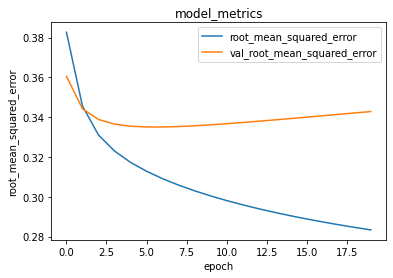

In [51]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['root_mean_squared_error', 'val_root_mean_squared_error'])
plt.show()

Dari hasil pelatihan yang dilakukan. Dapat dilihat bahwa nilai konvergen metrik RMSE berada di sekitar 0.28 untuk training dan disekitar 0.35 untuk validasi.